In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, LSTM
from tensorflow.keras.callbacks import EarlyStopping

import optuna
from optuna.trial import Trial

from typing import Tuple, Optional

import time
import os

2025-06-26 10:16:34.770082: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750932995.011908      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750932995.081861      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# dataset load

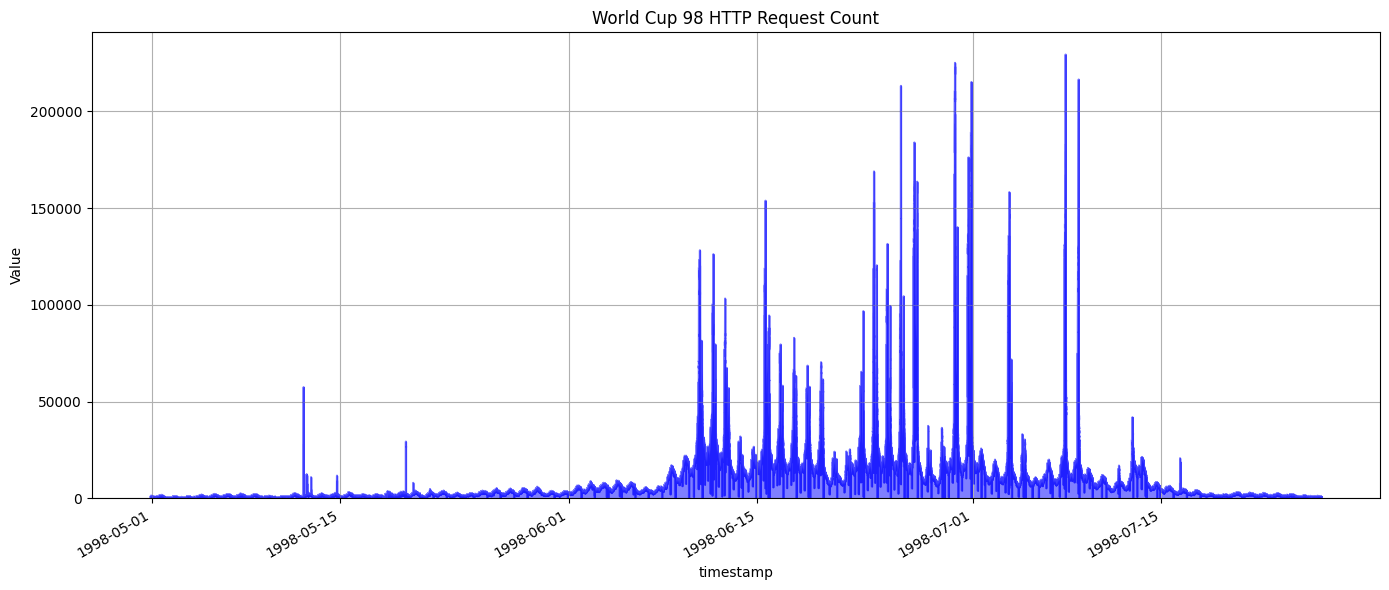

In [ ]:
wcdf = pd.read_csv(
        '/kaggle/input/worldcup98/worldcup98.csv',
        usecols=['timestamp', 'value'],
        index_col='timestamp',
        parse_dates=['timestamp']
    ).sort_index()

plt.figure(figsize=(14, 6))

wcdf['value'].plot(kind='area', color='blue', alpha=0.5)

plt.title('World Cup 98 HTTP Request Count')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

# helper

### create sequences aware slit func

In [ ]:
def sequences_aware_split(df, train_ratio=0.7, time_step=10):
    """
    Split DataFrame into train and test sets while preserving sequence continuity.
    
    Args:
        df: DataFrame to split, typically containing time-series data
        train_ratio (float): Proportion of sequences to allocate for training (default: 0.7)
        time_step (int): Length of each sequence/window for time-series modeling (default: 10)
        
    Returns:
        tuple: A tuple containing:
            - train_df: Training DataFrame with sufficient data for sequence creation
            - test_df: Testing DataFrame with remaining data
    """
    total_len = len(df)
    
    available_for_sequences = total_len - time_step
    train_sequences = int(available_for_sequences * train_ratio)
    
    split_point = train_sequences + time_step
    
    train_df = df.iloc[:split_point]
    test_df = df.iloc[split_point:]
    
    return train_df, test_df

### create sequence func

In [ ]:
def sequences(dataset: pd.DataFrame, time_step: int = 10):
    """
    Create sliding window sequences from time-series data for supervised learning.
    
    Args:
        dataset (pd.DataFrame): Time-series data to convert into sequences
        time_step (int): Length of each input sequence window (default: 10)
        
    Returns:
        list: A list containing two numpy arrays:
            - X (np.ndarray): Input sequences of shape (num_sequences, time_step, features)
            - y (np.ndarray): Target values of shape (num_sequences, features)
    """
    x, y = [], []
    
    for i in range(len(dataset) - time_step):
        x.append(dataset[i:i + time_step])
        y.append(dataset[i + time_step])
    
    return [np.array(x), np.array(y)]

### train model class

In [ ]:
class BilstmTrainer:
    """
    Trainer for Bidirectional LSTM models for time-series forecasting.
    """
    
    def __init__(self, hidden_units: int = 32, num_layers: int = 1, input_shape: tuple = (10, 1)):
        """
        Initialize BilstmTrainer and create the model architecture.
        
        Args:
            hidden_units (int): Number of LSTM units in each layer (default: 32)
            num_layers (int): Number of stacked Bidirectional LSTM layers (default: 1)
            input_shape (tuple): Shape of input sequences (timesteps, features) (default: (10, 1))
        """
        self.hidden_units = hidden_units
        self.num_layers = num_layers
        self.input_shape = input_shape
        self.model = self._create_model()
        self.history = None
        self.scaler = None
        self.train_data = None
        self.test_data = None
        self.y_test = None
        self.y_pred = None
        self.y_test_value = None
        self.y_pred_value = None

    def _create_model(self):
        """
        Create a stacked Bidirectional LSTM model architecture.
        
        Builds a Sequential model with configurable number of Bidirectional LSTM layers
        followed by a Dense output layer. Uses ReLU activation and MSE loss with Adam optimizer.
        
        Returns:
            Sequential: Compiled Keras model ready for training
        """
        model = Sequential()

        for i in range(self.num_layers):
            return_sequences = i < self.num_layers - 1

            if i == 0:
                model.add(Bidirectional(LSTM(
                    units=self.hidden_units, 
                    activation='relu', 
                    return_sequences=return_sequences, 
                    input_shape=self.input_shape
                )))
            else:
                model.add(Bidirectional(LSTM(
                    units=self.hidden_units, 
                    activation='relu', 
                    return_sequences=return_sequences
                )))

        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

        return model

    def fit_model(self, train_data: Optional[Tuple[np.ndarray, np.ndarray]], 
                  epochs: int = 50, batch_size: int = 64, 
                  patience: int = 5, verbose: int = 1):
        """
        Train the model with early stopping.
        
        Fits the model on training data with automatic validation split and early stopping
        to prevent overfitting. Stores training history for later visualization.
        
        Args:
            train_data (Optional[Tuple[np.ndarray, np.ndarray]]): Tuple of (X_train, y_train)
            epochs (int): Maximum number of training epochs (default: 50)
            batch_size (int): Number of samples per gradient update (default: 64)
            patience (int): Number of epochs with no improvement before stopping (default: 5)
            verbose (int): Verbosity mode (0=silent, 1=progress bar, 2=one line per epoch) (default: 1)
        """
        self.train_data = train_data
        
        early_stopping = EarlyStopping(
            monitor='val_loss', 
            patience=patience, 
            restore_best_weights=True
        )

        self.history = self.model.fit(
            train_data[0], train_data[1], 
            validation_split=0.2, 
            epochs=epochs, 
            batch_size=batch_size, 
            callbacks=[early_stopping],
            verbose=verbose
        )

    def plot_history(self):
        """
        Visualize training and validation loss over epochs.
        
        Creates a line plot showing the model's training and validation loss progression,
        useful for diagnosing overfitting or underfitting.
        """
        plt.figure(figsize=(14, 6))

        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')

        plt.title('Model Training History')
        plt.ylabel('Loss (MSE)')
        plt.xlabel('Epoch')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def evaluate_model(self, test_data: Optional[Tuple[np.ndarray, np.ndarray]]):
        """
        Evaluate model performance on test data.
                
        Args:
            test_data (Optional[Tuple[np.ndarray, np.ndarray]]): Tuple of (X_test, y_test)
            
        Returns:
            float: Test loss (Mean Squared Error)
        """
        self.test_data = test_data
        test_loss = self.model.evaluate(test_data[0], test_data[1])
        return test_loss

    def set_scaler(self, scaler: Optional[TransformerMixin]):
        """
        Set the data scaler for inverse transformations.
        
        Args:
            scaler (Optional[TransformerMixin]): Fitted scaler (e.g., MinMaxScaler, StandardScaler)
        """
        self.scaler = scaler

    def _predict(self):
        """
        Generate predictions on test data.
        
        Returns:
            np.ndarray: Model predictions in scaled form
        """
        return self.model.predict(self.test_data[0])

    def plot_prediction(self, test_df: pd.DataFrame, time_step: int = 10):
        """
        Visualize actual vs predicted values on test set.
        
        Creates a comparison plot of actual and predicted values, with predictions
        and actuals transformed back to original scale using the stored scaler.
        
        Args:
            test_df (pd.DataFrame): Original test DataFrame with time index
            time_step (int): Sequence length used for creating sequences (default: 10)
        """
        self.y_test = self.test_data[1]
        self.y_pred = self._predict()
        
        # Transform back to original scale
        self.y_test_value = self.scaler.inverse_transform(self.y_test.reshape(-1, 1))
        self.y_pred_value = self.scaler.inverse_transform(self.y_pred.reshape(-1, 1))
        
        # Align indices with original test data
        test_index = test_df.index[time_step - 1:time_step - 1 + len(self.y_test)]
        
        y_test_value_df = pd.DataFrame(self.y_test_value, index=test_index, columns=['value'])
        y_pred_value_df = pd.DataFrame(self.y_pred_value, index=test_index, columns=['value'])
        
        plt.figure(figsize=(14, 6))
        
        plt.plot(y_test_value_df.index, y_test_value_df['value'], label='Actual')
        plt.plot(y_pred_value_df.index, y_pred_value_df['value'], label='Predicted')
        
        plt.title('HTTP Workload Prediction')
        plt.ylabel('Number of Requests')
        plt.xlabel('Time')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def calculate_metrics(self):
        """
        Calculate regression metrics for model predictions.
        
        Returns:
            dict: Dictionary containing:
                - mean_squared_error (float): MSE score
                - root_mean_squared_error (float): RMSE score
                - mean_absolute_error (float): MAE score
                - r_squared (float): R² score
        """
        test_mae = mean_absolute_error(self.y_test_value, self.y_pred_value)
        test_mse = mean_squared_error(self.y_test_value, self.y_pred_value)
        test_rmse = np.sqrt(mean_squared_error(self.y_test_value, self.y_pred_value))
        test_r2 = r2_score(self.y_test_value, self.y_pred_value)

        metrics = {
            "mean_squared_error": test_mse,
            "root_mean_squared_error": test_rmse,
            "mean_absolute_error": test_mae,
            "r_squared": test_r2
        }

        return metrics

    def calculate_prediction_speed(self, warmup_runs: int = 3, n_runs: int = 30):
        """
        Benchmark model inference speed.
        
        Measures prediction latency for both batch and single-sample inference,
        with warmup runs and outlier removal for stable measurements.
        
        Args:
            warmup_runs (int): Number of warmup predictions to stabilize timing (default: 3)
            n_runs (int): Number of timed prediction runs (default: 30)
            
        Returns:
            dict: Dictionary containing:
                - avg_batch_time_seconds (float): Average time for full batch prediction
                - avg_single_prediction_ms (float): Average time for single prediction in milliseconds
                - std_batch_time_seconds (float): Standard deviation for batch predictions
                - std_single_prediction_ms (float): Standard deviation for single predictions in milliseconds
        """
        x_test = self.test_data[0]
        single_sample = x_test[:1]

        # Warmup runs to stabilize GPU/CPU
        for _ in range(warmup_runs):
            _ = self.model.predict(x_test, verbose=0)

        # Batch prediction timing
        times_batch_pred = []
        
        for run in range(n_runs):
            start_time = time.perf_counter()
            predictions = self.model.predict(x_test, verbose=0)
            end_time = time.perf_counter()
            
            times_batch_pred.append(end_time - start_time)
        
        # Remove outliers (top and bottom 2)
        times_batch_pred = sorted(times_batch_pred)[2:-2]
        
        avg_time_batch = np.mean(times_batch_pred)
        std_time_batch = np.std(times_batch_pred)
        
        # Single prediction timing
        times_single_pred = []

        for run in range(n_runs):
            start_time = time.perf_counter()
            prediction = self.model.predict(single_sample, verbose=0)
            end_time = time.perf_counter()
            
            times_single_pred.append(end_time - start_time)

        # Remove outliers (top and bottom 5)
        times_single_pred = sorted(times_single_pred)[5:-5]
        
        avg_time_single = np.mean(times_single_pred)
        std_time_single = np.std(times_single_pred)
        
        speed_metrics = {
            "avg_batch_time_seconds": avg_time_batch,
            "avg_single_prediction_ms": avg_time_single * 1000,
            "std_batch_time_seconds": std_time_batch,
            "std_single_prediction_ms": std_time_single * 1000,
        }
        
        return speed_metrics

    def save_model(self, model_name: str, path: str = "."):
        """
        Save the trained model to disk in SavedModel format.
        
        Exports the model in TensorFlow SavedModel format for deployment and inference.
        
        Args:
            model_name (str): Name for the saved model directory
            path (str): Directory path where model should be saved (default: current directory)
        """
        tf.saved_model.save(self.model, f'{path}/{model_name}')
        print(f"{model_name} saved successfully")

### hyperparameters optimization func

In [ ]:
# custom type aliases 
train_data = Optional[Tuple[np.ndarray, np.ndarray]]
test_data = Optional[Tuple[np.ndarray, np.ndarray]]

def objective(trial: Trial, 
              train_data: train_data = None, 
              test_data: test_data = None):
    """
    Optuna objective function for hyperparameter optimization.
    
    Args:
        trial (Trial): Optuna trial object for suggesting hyperparameters
        train_data (Optional[Tuple[np.ndarray, np.ndarray]]): Tuple of (X_train, y_train)
        test_data (Optional[Tuple[np.ndarray, np.ndarray]]): Tuple of (X_test, y_test)
        
    Returns:
        float: Test loss (MSE) to be minimized by Optuna
    """
    # Suggest hyperparameters
    hidden_units = trial.suggest_int('hidden_units', 30, 100, log=True)
    num_layers = trial.suggest_categorical('num_layers', [1, 2])
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256, 512])
    epochs = trial.suggest_categorical('epochs', [50, 100, 150, 250])
    patience = trial.suggest_categorical('patience', [5, 10])

    # Create and train model with suggested hyperparameters
    bilstm_trial = BilstmTrainer(
        hidden_units=hidden_units, 
        num_layers=num_layers, 
        input_shape=(10, 1)
    )
    
    bilstm_trial.fit_model(
        train_data=train_data,
        epochs=epochs, 
        batch_size=batch_size,
        patience=patience,
        verbose=0
    )
    
    # Evaluate on test set
    test_loss = bilstm_trial.evaluate_model(test_data)

    # Clear session to free memory
    tf.keras.backend.clear_session()

    return test_loss


def hyperparameter_tuning(train_data: Optional[Tuple[np.ndarray, np.ndarray]] = None, 
                          test_data: Optional[Tuple[np.ndarray, np.ndarray]] = None, 
                          n_trials: int = 50):
    """
    Perform Bayesian hyperparameter optimization for BiLSTM model.
    
    Args:
        train_data (Optional[Tuple[np.ndarray, np.ndarray]]): Tuple of (X_train, y_train)
        test_data (Optional[Tuple[np.ndarray, np.ndarray]]): Tuple of (X_test, y_test)
        n_trials (int): Number of optimization trials to run (default: 50)
        
    Returns:
        Dict[str, Any]: Dictionary containing best hyperparameter values found:
            - hidden_units (int): Optimal number of LSTM units
            - num_layers (int): Optimal number of stacked layers
            - batch_size (int): Optimal batch size
            - epochs (int): Optimal number of epochs
            - patience (int): Optimal early stopping patience
    """
    study = optuna.create_study(
        study_name='bilstm hyperparameters optimization',
        direction='minimize', 
        sampler=optuna.samplers.TPESampler(seed=42), 
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
    )

    objective_with_params = lambda trial: objective(trial, train_data, test_data)
    
    study.optimize(objective_with_params, n_trials=n_trials, show_progress_bar=True)

    return study.best_params

# dataset preprocessing

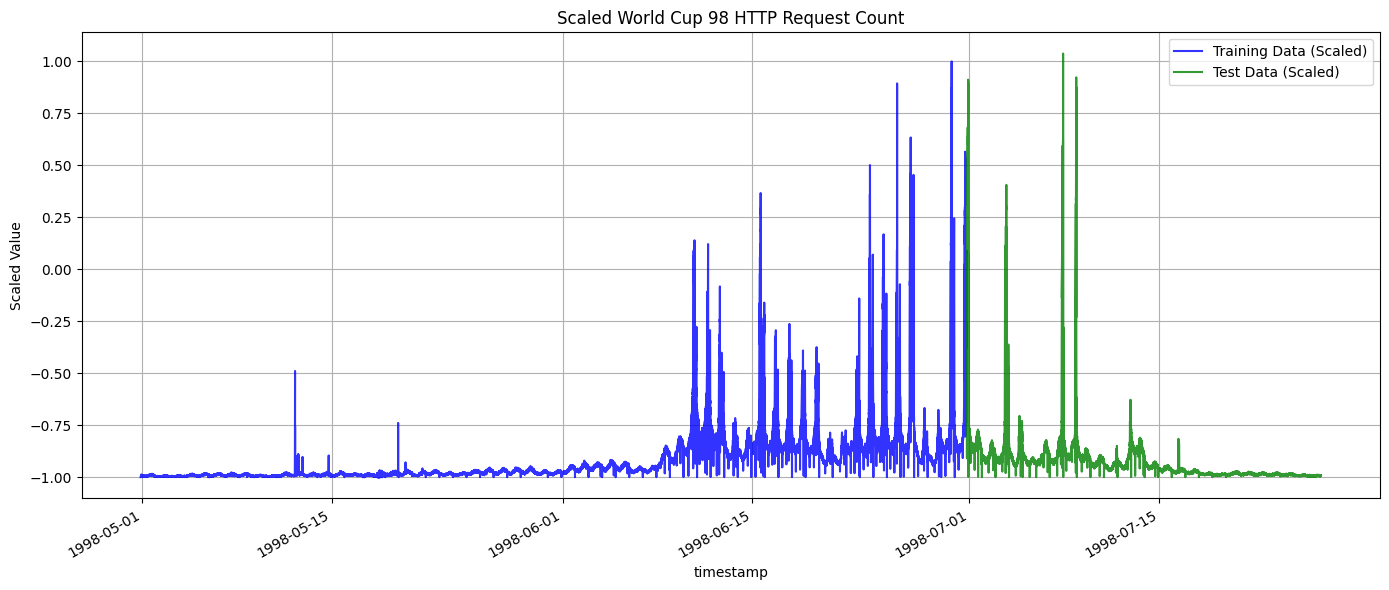

In [ ]:
train_df, test_df = sequences_aware_split(wcdf)

scaler = MinMaxScaler(feature_range=(-1, 1))
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)

train_data = sequences(train_scaled)
test_data = sequences(test_scaled)

train_scaled_df = pd.DataFrame(train_scaled, index=train_df.index, columns=['scaled_value'])
test_scaled_df = pd.DataFrame(test_scaled, index=test_df.index, columns=['scaled_value'])

plt.figure(figsize=(14, 6))

train_scaled_df['scaled_value'].plot(label='Training Data (Scaled)', color='blue', alpha=0.8)
test_scaled_df['scaled_value'].plot(label='Test Data (Scaled)', color='green', alpha=0.8)

plt.title('Scaled World Cup 98 HTTP Request Count')
plt.ylabel('Scaled Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# creating model

### hyperparameter config 1 from Dang-Quang et al., (2021)

Epoch 1/50


I0000 00:00:1750933011.231625      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750933011.232317      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1750933018.856918      65 service.cc:148] XLA service 0x7ea7f4003c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750933018.857531      65 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Ca

  37/1099 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.4649

I0000 00:00:1750933021.931956      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1099/1099 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0416 - val_loss: 0.0024
Epoch 2/50
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2.5761e-04 - val_loss: 0.0019
Epoch 3/50
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2.3499e-04 - val_loss: 0.0026
Epoch 4/50
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.6451e-04 - val_loss: 0.0016
Epoch 5/50
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.6017e-04 - val_loss: 0.0025
Epoch 6/50
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.7268e-04 - val_loss: 0.0020
Epoch 7/50
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.3249e-04 - val_loss: 0.0015
Epoch 8/50
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.8933e-04 - val_loss: 0.0015
Epoch 9/50
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.6873e-04 - val_loss: 0.0022
Epoch 10/50
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.7222e-04 - val_loss: 0.0032
Epoch 11/50
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.9390e-04 - val_loss: 0.0041


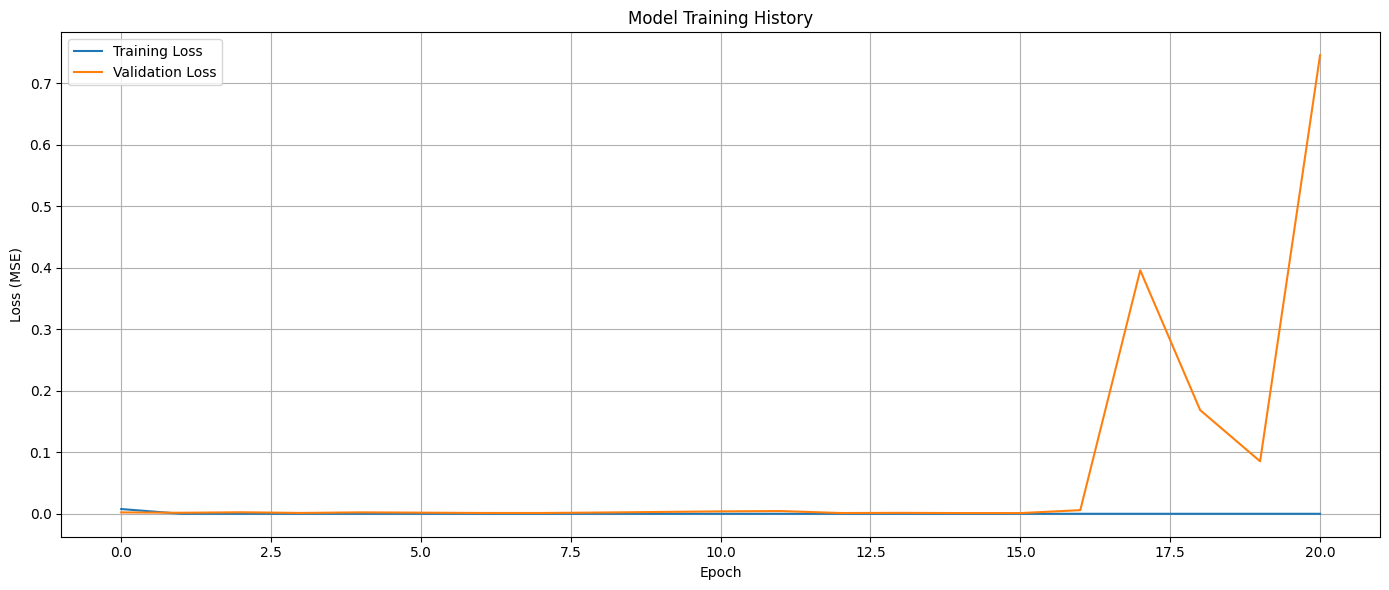

1177/1177 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


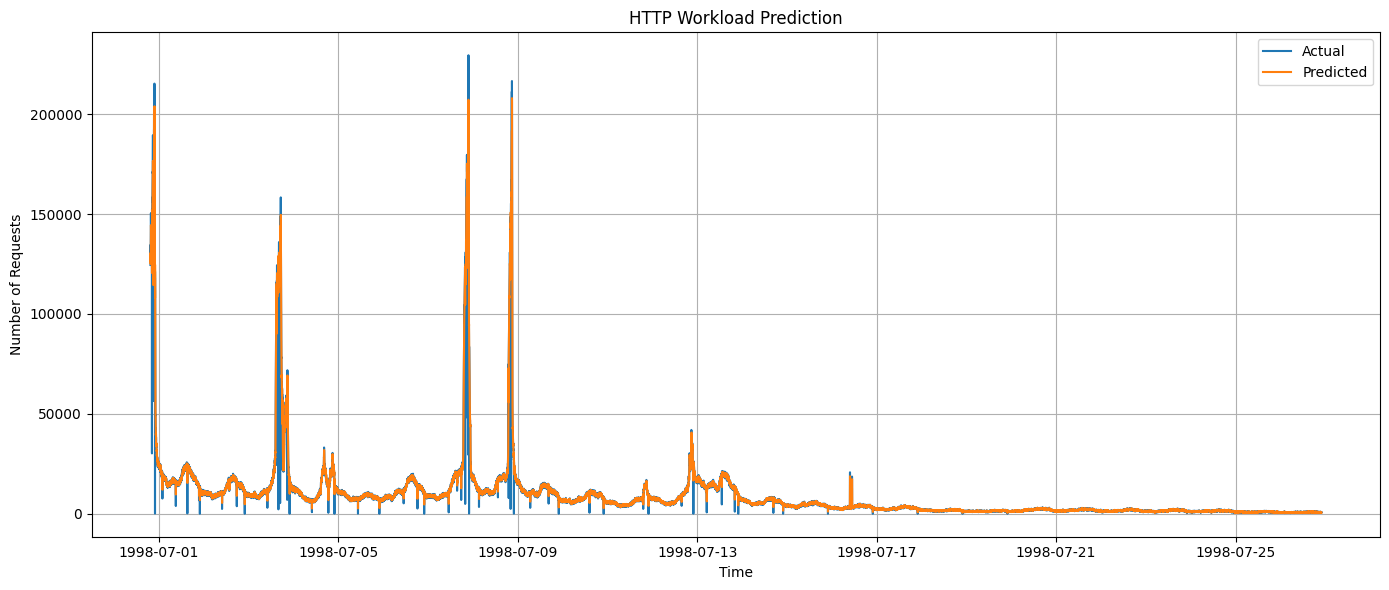

In [ ]:
bilstm_dq = BilstmTrainer(hidden_units=30, num_layers=2, input_shape=(10, 1))

bilstm_dq.fit_model(train_data=train_data, epochs=50, batch_size=64, patience=5)
bilstm_dq.plot_history()

test_loss_dq = bilstm_dq.evaluate_model(test_data)

bilstm_dq.set_scaler(scaler)
bilstm_dq.plot_prediction(test_df=test_df, time_step=10)

### hyperparameter config 2 from  Mondal et al., (2023)

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.1900 - val_loss: 0.0026
Epoch 2/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.4126e-04 - val_loss: 0.0026
Epoch 3/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.1237e-04 - val_loss: 0.0026
Epoch 4/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.0567e-04 - val_loss: 0.0021
Epoch 5/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9565e-04 - val_loss: 0.0021
Epoch 6/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5544e-04 - val_loss: 0.0021
Epoch 7/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9020e-04 - val_loss: 0.0017
Epoch 8/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.1964e-04 - val_loss: 0.0016
Epoch 9/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.0839e-04 - val_loss: 0.0018
Epoch 10/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6583e-04 - val_loss: 0.0017
Epoch 11/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.0005e-04 - val_loss: 0.0017
Epoch 12/200

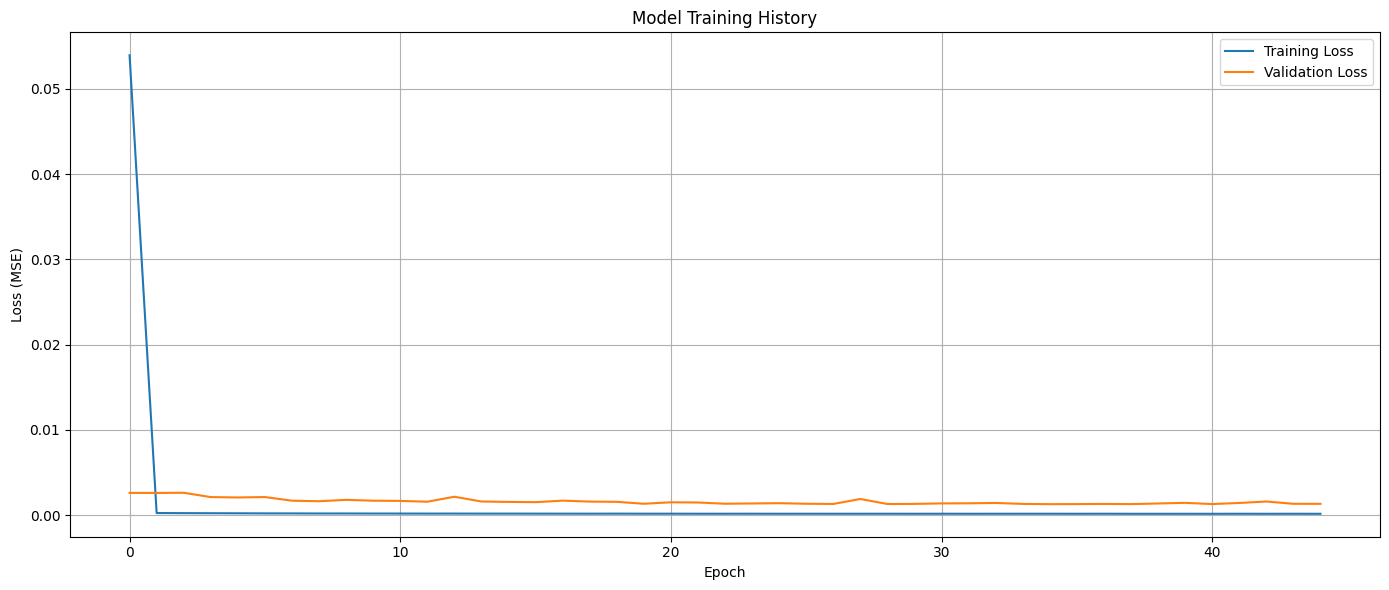

1177/1177 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


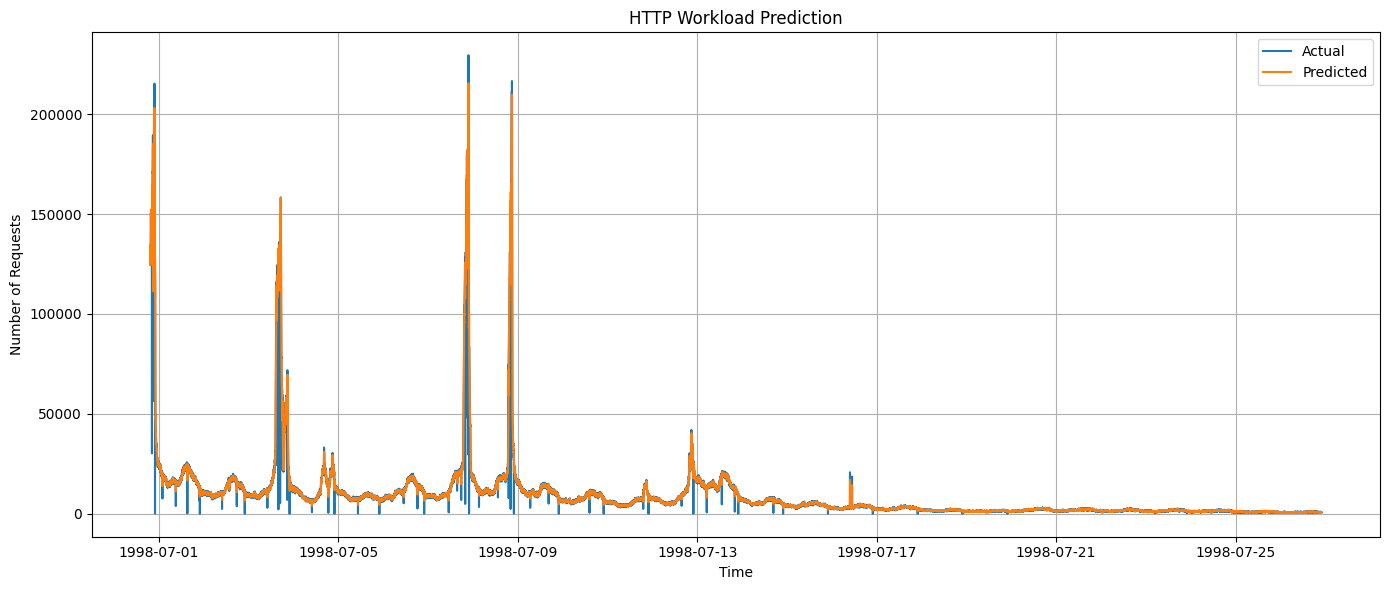

In [ ]:
bilstm_md = BilstmTrainer(hidden_units=100, num_layers=1, input_shape=(10, 1))

bilstm_md.fit_model(train_data=train_data, epochs=200, batch_size=512, patience=10)
bilstm_md.plot_history()

test_loss_md = bilstm_md.evaluate_model(test_data)

bilstm_md.set_scaler(scaler)
bilstm_md.plot_prediction(test_df=test_df, time_step=10)

### hyperparametes optmization

In [ ]:
best_params = hyperparameter_tuning(
        train_data=train_data,
        test_data=test_data,
        n_trials=100
    )

[I 2025-06-26 10:19:56,436] A new study created in memory with name: bilstm hyperparameters optimization


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1177/1177 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0015
[I 2025-06-26 10:20:59,186] Trial 0 finished with value: 0.0005496705416589975 and parameters: {'hidden_units': 47, 'num_layers': 1, 'batch_size': 64, 'epochs': 50, 'patience': 5}. Best is trial 0 with value: 0.0005496705416589975.
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0014
[I 2025-06-26 10:22:33,394] Trial 1 finished with value: 0.0005271018017083406 and parameters: {'hidden_units': 38, 'num_layers': 2, 'batch_size': 128, 'epochs': 50, 'patience': 10}. Best is trial 1 with value: 0.0005271018017083406.
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0020
[I 2025-06-26 10:23:27,601] Trial 2 finished with value: 0.0007199226529337466 and parameters: {'hidden_units': 38, 'num_layers': 2, 'batch_size': 128, 'epochs': 100, 'patience': 10}. Best is trial 1 with value: 0.0005271018017083406.
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0015
[I 2025-06-26 10:24:49,404] Trial 3 finished with value: 0.00052341

### model with best hyperparameters config

In [11]:
print(best_params)

{'hidden_units': 34, 'num_layers': 1, 'batch_size': 64, 'epochs': 100, 'patience': 10}


Epoch 1/100
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0651 - val_loss: 0.0023
Epoch 2/100
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.2337e-04 - val_loss: 0.0021
Epoch 3/100
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.7611e-04 - val_loss: 0.0019
Epoch 4/100
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.5529e-04 - val_loss: 0.0024
Epoch 5/100
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.9943e-04 - val_loss: 0.0016
Epoch 6/100
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.8843e-04 - val_loss: 0.0015
Epoch 7/100
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.6234e-04 - val_loss: 0.0015
Epoch 8/100
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.8247e-04 - val_loss: 0.0015
Epoch 9/100
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.6290e-04 - val_loss: 0.0014
Epoch 10/100
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.9860e-04 - val_loss: 0.0014
Epoch 11/100
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.6516e-

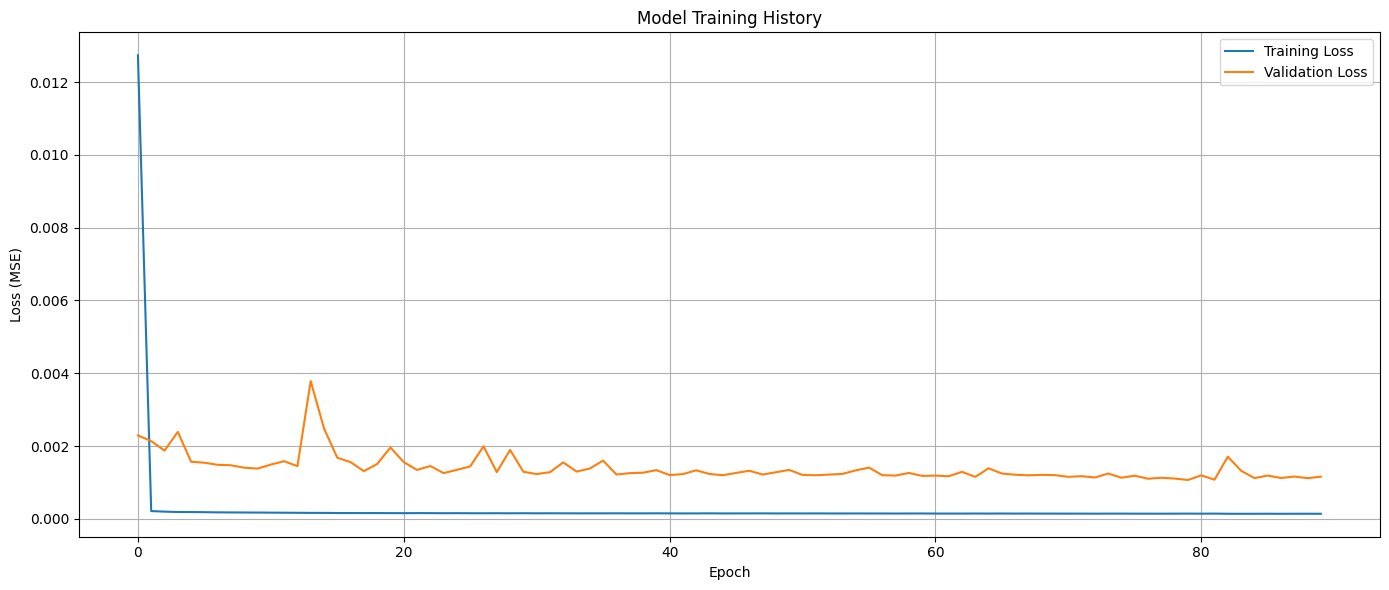

1177/1177 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


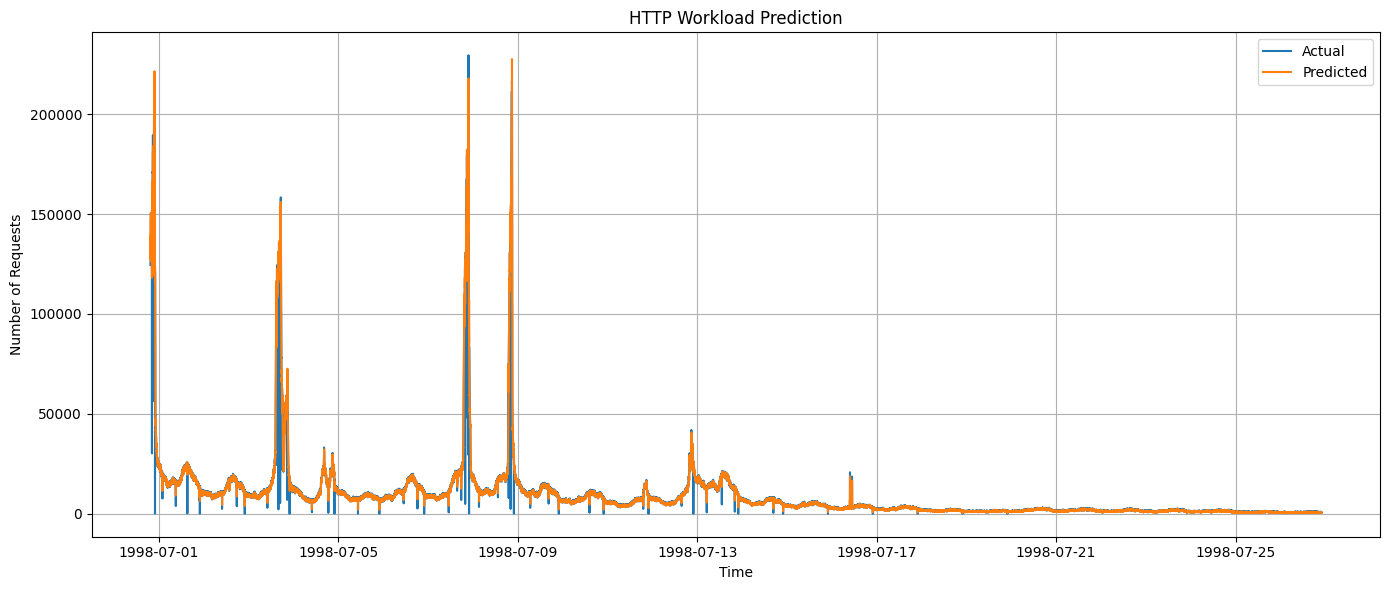

In [ ]:
bilstm_opt = BilstmTrainer(
        hidden_units=best_params['hidden_units'], 
        num_layers=best_params['num_layers'], 
        input_shape=(10, 1)
    )
bilstm_opt.fit_model(
        train_data=train_data, 
        epochs=best_params['epochs'], 
        batch_size=best_params['batch_size'],
        patience=best_params['patience']
    )
bilstm_opt.plot_history()

test_loss_opt = bilstm_opt.evaluate_model(test_data)

bilstm_opt.set_scaler(scaler)
bilstm_opt.plot_prediction(test_df=test_df, time_step=10)

# model evaluation

### metrics comparison

In [13]:
metrics_dq = bilstm_dq.calculate_metrics()
metric_speed_dq = bilstm_dq.calculate_prediction_speed()

metrics_md = bilstm_md.calculate_metrics()
metric_speed_md = bilstm_md.calculate_prediction_speed()

metrics_opt = bilstm_opt.calculate_metrics()
metric_speed_opt = bilstm_opt.calculate_prediction_speed()

print("hyperparameter 1")
print(f"test loss : {test_loss_dq:.6f}")
print("hyperparameter 2")
print(f"test loss : {test_loss_md:.6f}")
print("hyperparameter optimized")
print(f"test loss : {test_loss_opt:.6f}")

hyperparameter 1
test loss : 0.000533
hyperparameter 2
test loss : 0.000517
hyperparameter optimized
test loss : 0.000436


In [14]:
print("real value")
print("\n")
print("hyperparameter 1")
for metric, value in metrics_dq.items():
    print(f"- {metric}: {value:.6f}")

print("===")

print("hyperparameter 2")
for metric, value in metrics_md.items():
    print(f"- {metric}: {value:.6f}")

print("===")
    
print("hyperparameter optimized")
for metric, value in metrics_opt.items():
    print(f"- {metric}: {value:.6f}")

real value


hyperparameter 1
- mean_squared_error: 6757735.425451
- root_mean_squared_error: 2599.564468
- mean_absolute_error: 495.001446
- r_squared: 0.980609
===
hyperparameter 2
- mean_squared_error: 6557045.181323
- root_mean_squared_error: 2560.672799
- mean_absolute_error: 477.636287
- r_squared: 0.981184
===
hyperparameter optimized
- mean_squared_error: 5528303.780442
- root_mean_squared_error: 2351.234523
- mean_absolute_error: 460.337935
- r_squared: 0.984136


In [15]:
print("prediction speed")
print("\n")
print("hyperparameter 1")
for metric, value in metric_speed_dq.items():
    print(f"- {metric}: {value:.2f}")

print("===")

print("hyperparameter 2")
for metric, value in metric_speed_md.items():
    print(f"- {metric}: {value:.2f}")

print("===")
    
print("hyperparameter optimized")
for metric, value in metric_speed_opt.items():
    print(f"- {metric}: {value:.2f}")

prediction speed


hyperparameter 1
- avg_batch_time_seconds: 2.53
- avg_single_prediction_ms: 58.09
- std_batch_time_seconds: 0.03
- std_single_prediction_ms: 1.54
===
hyperparameter 2
- avg_batch_time_seconds: 1.74
- avg_single_prediction_ms: 61.08
- std_batch_time_seconds: 0.02
- std_single_prediction_ms: 1.89
===
hyperparameter optimized
- avg_batch_time_seconds: 1.78
- avg_single_prediction_ms: 58.00
- std_batch_time_seconds: 0.03
- std_single_prediction_ms: 1.22


### model improvement after optimization

In [16]:
print(f"Improvement from config #1: {(test_loss_dq - test_loss_opt) / test_loss_dq * 100:.2f}%")

print(f"Improvement from config #2: {(test_loss_md  - test_loss_opt) / test_loss_md  * 100:.2f}%")

Improvement from config #1: 18.19%
Improvement from config #2: 15.69%


# saving model

In [17]:
bilstm_dq.save_model("bilstm_dq", "/kaggle/working")

bilstm_md.save_model("bilstm_md", "/kaggle/working")

bilstm_opt.save_model("bilstm_bo_opt", "/kaggle/working")

bilstm_dq saved successfully
bilstm_md saved successfully
bilstm_bo_opt saved successfully
